In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("data/data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [5]:
cols = ['Make', 'Model', 'Year', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP']

In [6]:
df = df[cols]

In [7]:
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,3916,34500


In [8]:
df.columns = df.columns.str.replace(' ', "_").str.lower()

In [9]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,3916,34500


In [10]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
popularity            0
msrp                  0
dtype: int64

In [11]:
df = df.fillna(0)

In [12]:
df.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

In [13]:
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype('int')

In [16]:
del df['msrp']

In [17]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,popularity,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,3916,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,3916,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,3916,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,3916,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,3916,0


In [23]:
def split_data(df):
    df = df.copy()
    y_full = df['above_average'].values
    del df['above_average']
    
    df_train_full, df_test, y_train_full, y_test = train_test_split(df, y_full, test_size=0.2, random_state=1)
    df_train, df_val, y_train, y_val = train_test_split(df_train_full, y_train_full, test_size=0.25, random_state=1)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [24]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [26]:
df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
above_average          int64
dtype: object

In [31]:
numerical = [c for c in df_train.columns if df[c].dtype != 'object']

In [32]:
numerical

['year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg',
 'popularity']

In [35]:
for f in numerical:
    auc = round(roc_auc_score(y_train, df_train[f]), 3)
    if auc < 0.5:
        auc = -1 * auc
    print(f"{f} --->  auc: {auc}")

year --->  auc: 0.688
engine_hp --->  auc: 0.917
engine_cylinders --->  auc: 0.766
highway_mpg --->  auc: -0.367
city_mpg --->  auc: -0.327
popularity --->  auc: -0.479


answer: engine_hp

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [49]:
def train_log_reg(df_train, df_val, y_train, y_val):
    df_train = df_train.copy()
    df_val = df_val.copy()

    dv = DictVectorizer(sparse=False)

    dicts_train = df_train.to_dict(orient="records")
    dicts_val = df_val.to_dict(orient="records")
    
    X_train= dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_pred)
    
    return round(roc, 3)

   

In [50]:
train_log_reg(df_train, df_val, y_train, y_val)

0.973

In [39]:
dv = DictVectorizer(sparse=False)

dicts_train = df_train.to_dict(orient="records")
dicts_val = df_val.to_dict(orient="records")

X_train= dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)




In [43]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [46]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
roc = roc_auc_score(y_val, y_pred)
round(roc, 3)

0.973

answer: closest is 0.979

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


In [51]:
thresholds = np.linspace(0.0, 1.0, num=101)

In [91]:
def precision_recall_f1(df_train, df_val, y_train, y_val, threshold):
    df_train = df_train.copy()
    df_val = df_val.copy()

    dv = DictVectorizer(sparse=False)

    dicts_train = df_train.to_dict(orient="records")
    dicts_val = df_val.to_dict(orient="records")
    
    X_train= dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)

    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_val)[:, 1] > threshold)
    #roc = roc_auc_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1_sc = f1_score(y_val, y_pred)

    
    
    return round(roc, 3), prec, rec, f1_sc


In [61]:
prec_scores = []
rec_scores = []
for t in thresholds:
    _, prec, rec = precision_recall(df_train, df_val, y_train, y_val, threshold=t)
    prec_scores.append(prec)
    rec_scores.append(rec)
    if prec > rec:
        print(f"precision intersects with recall at a threshold of {t}")
        break

# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, prec_scores, label='Precision')
# plt.plot(thresholds, rec_scores, label='Recall')
# plt.legend()



precision intersects with recall at a threshold of 0.47000000000000003


answer: the closest answer for the intersection appears to be intersection at around 0.48

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72


In [81]:
f1_scores = []
best_f1 = 0
best_pair = (0, 0)

for t in thresholds:
    _, prec, rec, f1 = precision_recall_f1(df_train, df_val, y_train, y_val, threshold=t)
    #f1_scores.append((t, f1))
    if f1 > best_f1:
        best_pair = (f1, t)
        
    
    
last_best_f1, best_threshold = best_pair
# #best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])
# best_threshold, best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {last_best_f1}")


Best Threshold: 0.99
Best F1 Score: 0.4372759856630824


/Users/isaachurwitz/opt/anaconda3/envs/mlc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


answer: the closest is 0.32

In [96]:
f1_scores = []
best_f1 = 0
best_pair = (0, 0)

for t in thresholds:
    _, prec, rec, f1 = precision_recall_f1(df_train, df_val, y_train, y_val, threshold=t)
    #f1_scores.append((t, f1))
    if f1 > best_f1:
        best_pair = (f1, t)
        
    
    
best_threshold, last_best_f1 = best_pair
# #best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])
# best_threshold, best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {last_best_f1}")


Best Threshold: 0.4372759856630824
Best F1 Score: 0.99


/Users/isaachurwitz/opt/anaconda3/envs/mlc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/isaachurwitz/opt/anaconda3/envs/mlc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


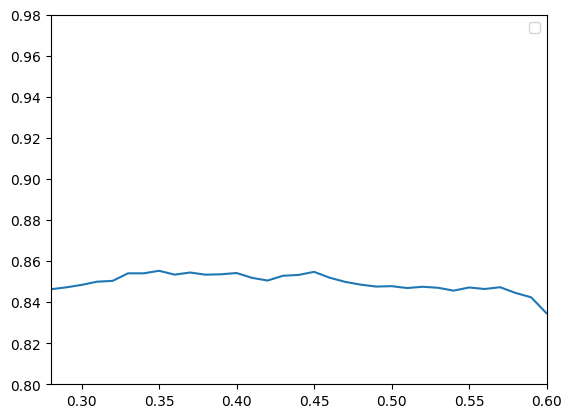

In [97]:
f1_scores = []

for t in thresholds:
    _, prec, rec, f1 = precision_recall_f1(df_train, df_val, y_train, y_val, threshold=t)
    
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores)
plt.xlim(0.28, 0.6)
plt.ylim(0.80, 0.98)
plt.legend()


ValueError: x and y must have same first dimension, but have shapes (101,) and (0,)

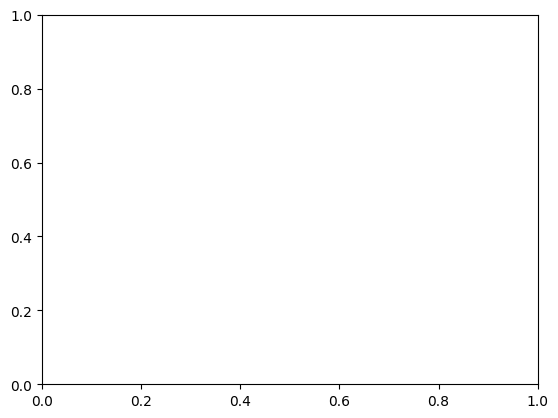

In [94]:
plt.plot(thresholds, f1_scores)

plt.ylim(0.80, 0.98)
plt.legend()


In [92]:
f1_scores = []

for t in thresholds:
    _, prec, rec, f1 = precision_recall_f1(df_train, df_val, y_train, y_val, threshold=t)
    
    print(f"threshold: {round(t, 2)} ----->  {round(f1, 3)}")

threshold: 0.0 ----->  0.431
threshold: 0.01 ----->  0.584
threshold: 0.02 ----->  0.641
threshold: 0.03 ----->  0.665
threshold: 0.04 ----->  0.69
threshold: 0.05 ----->  0.705
threshold: 0.06 ----->  0.722
threshold: 0.07 ----->  0.734
threshold: 0.08 ----->  0.749
threshold: 0.09 ----->  0.759
threshold: 0.1 ----->  0.77
threshold: 0.11 ----->  0.776
threshold: 0.12 ----->  0.785
threshold: 0.13 ----->  0.795
threshold: 0.14 ----->  0.8
threshold: 0.15 ----->  0.806
threshold: 0.16 ----->  0.81
threshold: 0.17 ----->  0.813
threshold: 0.18 ----->  0.818
threshold: 0.19 ----->  0.82
threshold: 0.2 ----->  0.822
threshold: 0.21 ----->  0.82
threshold: 0.22 ----->  0.821
threshold: 0.23 ----->  0.832
threshold: 0.24 ----->  0.837
threshold: 0.25 ----->  0.84
threshold: 0.26 ----->  0.842
threshold: 0.27 ----->  0.844
threshold: 0.28 ----->  0.846
threshold: 0.29 ----->  0.847
threshold: 0.3 ----->  0.848
threshold: 0.31 ----->  0.85
threshold: 0.32 ----->  0.85
threshold: 0.33 ----->  

/Users/isaachurwitz/opt/anaconda3/envs/mlc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
f1_scores = []

for t in thresholds:
    _, prec, rec, f1 = precision_recall_f1(df_train, df_val, y_train, y_val, threshold=t)
    
    print(f"threshold: {round(t, 2)} ----->  {round(f1, 3)}")

threshold: 0.0 ----->  0.431
threshold: 0.01 ----->  0.584
threshold: 0.02 ----->  0.641
threshold: 0.03 ----->  0.665
threshold: 0.04 ----->  0.69
threshold: 0.05 ----->  0.705
threshold: 0.06 ----->  0.722
threshold: 0.07 ----->  0.734
threshold: 0.08 ----->  0.749
threshold: 0.09 ----->  0.759
threshold: 0.1 ----->  0.77
threshold: 0.11 ----->  0.776
threshold: 0.12 ----->  0.785
threshold: 0.13 ----->  0.795
threshold: 0.14 ----->  0.8
threshold: 0.15 ----->  0.806
threshold: 0.16 ----->  0.81
threshold: 0.17 ----->  0.813
threshold: 0.18 ----->  0.818
threshold: 0.19 ----->  0.82
threshold: 0.2 ----->  0.822
threshold: 0.21 ----->  0.82
threshold: 0.22 ----->  0.821
threshold: 0.23 ----->  0.832
threshold: 0.24 ----->  0.837
threshold: 0.25 ----->  0.84
threshold: 0.26 ----->  0.842
threshold: 0.27 ----->  0.844
threshold: 0.28 ----->  0.846
threshold: 0.29 ----->  0.847
threshold: 0.3 ----->  0.848
threshold: 0.31 ----->  0.85
threshold: 0.32 ----->  0.85
threshold: 0.33 ----->  

/Users/isaachurwitz/opt/anaconda3/envs/mlc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/isaachurwitz/opt/anaconda3/envs/mlc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


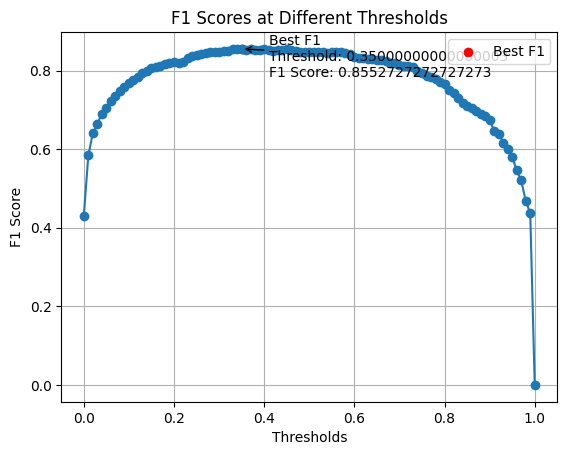

The threshold with the highest F1 score is 0.35000000000000003 (F1 Score: 0.8552727272727273)


In [105]:
f1_scores = []

for t in thresholds:
    _, prec, rec, f1 = precision_recall_f1(df_train, df_val, y_train, y_val, threshold=t)
    f1_scores.append((t, f1))


# Extract thresholds and F1 scores
thresholds, f1_values = zip(*f1_scores)

# Create a plot for F1 scores
plt.plot(thresholds, f1_values, marker='o', linestyle='-')

# Label the x and y axes
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')

# Find the threshold with the highest F1 score
best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])

# Mark the point with the highest F1 score
plt.scatter(best_threshold, best_f1, color='red', marker='o', label='Best F1')

# Annotate the highest F1 score
plt.annotate(f'Best F1\nThreshold: {best_threshold}\nF1 Score: {best_f1}', xy=(best_threshold, best_f1), xytext=(20, -20),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

# Show the plot
plt.grid(True)
plt.legend()
plt.title('F1 Scores at Different Thresholds')
plt.show()

# Print the threshold with the highest F1 score
print(f"The threshold with the highest F1 score is {best_threshold} (F1 Score: {best_f1})")

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [117]:
def log_reg(df_train, df_val, y_train, y_val):
    df_train = df_train.copy()
    df_val = df_val.copy()

    dv = DictVectorizer(sparse=False)

    dicts_train = df_train.to_dict(orient="records")
    dicts_val = df_val.to_dict(orient="records")
    
    X_train= dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_pred)
    
    return round(roc, 3)

In [ ]:
* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

In [129]:
def split_data(df):
    df = df.copy()
    y_full = df['above_average'].values
    del df['above_average']
    
    df_train_full, df_test, y_train_full, y_test = train_test_split(df, y_full, test_size=0.2, random_state=1)
    df_train, df_val, y_train, y_val = train_test_split(df_train_full, y_train_full, test_size=0.25, random_state=1)

    return df_train_full, df_train, df_val, df_test, y_train_full, y_train, y_val, y_test

In [130]:
df_train_full, df_train, df_val, df_test, y_train_full, y_train, y_val, y_test = split_data(df)

In [131]:
len(df_train_full), len(y_train_full)

(9531, 9531)

In [134]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [136]:
scores = []

for train_idx, val_idx in kf.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = y_train_full[train_idx]
        y_val = y_train_full[val_idx]

        # dv, model = train(df_train, y_train, C=C)
        # y_pred = predict(df_val, dv, model)
    

        auc = log_reg(df_train, df_val, y_train, y_val)
        scores.append(auc)


print(f"std:  {round(np.std(scores), 3)}")

std:  0.004


answer: closest is 0.003


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

In [138]:
def log_reg_tune_C(df_train, df_val, y_train, y_val, C=1.0):
    df_train = df_train.copy()
    df_val = df_val.copy()

    dv = DictVectorizer(sparse=False)

    dicts_train = df_train.to_dict(orient="records")
    dicts_val = df_val.to_dict(orient="records")
    
    X_train= dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_pred)
    
    return round(roc, 3)

In [140]:
for C in [0.01, 0.1, 0.5, 10]:

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kf.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = y_train_full[train_idx]
        y_val = y_train_full[val_idx]

        # dv, model = train(df_train, y_train, C=C)
        # y_pred = predict(df_val, dv, model)
    

        auc = log_reg_tune_C(df_train, df_val, y_train, y_val, C=C)
        scores.append(auc)

    mean_auc = round(np.mean(scores), 5)
    auc_std = round(np.std(scores),3)
    print(F"C:{C} ---- mean_auc: {mean_auc} ----- std: {auc_std}")
    print()



    

C:0.01 ---- mean_auc: 0.9508 ----- std: 0.003

C:0.1 ---- mean_auc: 0.9708 ----- std: 0.002

C:0.5 ---- mean_auc: 0.979 ----- std: 0.004

C:10 ---- mean_auc: 0.9792 ----- std: 0.004



If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`

given the above criteria I guess 0.5 is the winner since it has the same mean auc as c of 10 with same std but it is lower